# 4. Comparative Analysis: Apriori vs. FP-Growth in Market Basket Analysis

This notebook explores and compares two major algorithms used in Market Basket Analysis: **Apriori** and **FP-Growth**. Each section addresses a specific question to guide analysis and highlight both strengths and limitations of the algorithms in a real-world retail dataset.

### Business & Analytical Questions:
- **4.1**: How do we prepare and encode transactional data for Market Basket Analysis?  
  _This step ensures our raw purchase data is formatted for association rule mining._

- **4.2**: What are the frequent itemsets identified using the Apriori algorithm?  
  _Identifies commonly co-purchased items using the traditional Apriori approach._

- **4.3**: What association rules can be derived from Apriori, and how strong are they?  
  _Assesses Apriori’s ability to generate actionable if-then rules from frequent sets._

- **4.4**: What are the frequent itemsets discovered using the FP-Growth algorithm?  
  _Uses FP-Growth’s tree-based approach to uncover frequent combinations more efficiently._

- **4.5**: What association rules can be derived from FP-Growth, and how do they compare to Apriori?  
  _Comparison of rule quality and insights from the two algorithms._

- **4.6**: How do Apriori and FP-Growth compare in terms of performance (speed, scalability)?  
  _Benchmarks the algorithms on processing time and efficiency._

- **4.7**: What are the key takeaways from comparing both algorithms?  
  _Summarizes strengths, weaknesses, and recommended use cases._

---


In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

### 4.1 How do we prepare and encode transactional data for Market Basket Analysis?

In [2]:
base_path = r"E:\Semester 2\Research Proposal\Msc Dissertation\Insta Cart data Set"

orders_df = pd.read_csv(f"{base_path}\\orders.csv", usecols=['order_id', 'user_id', 'order_number', 'eval_set'])

products_df = pd.read_csv(f"{base_path}\\products.csv", usecols=['product_id', 'product_name', 'aisle_id', 'department_id'])
order_products_df = pd.read_csv(f"{base_path}\\order_products__prior.csv", usecols=['order_id', 'product_id'])
aisles_df = pd.read_csv(f"{base_path}\\aisles.csv", usecols=['aisle_id', 'aisle'])
department_df = pd.read_csv(f"{base_path}\\departments.csv", usecols=['department_id', 'department'])

In [3]:
sample_ids = order_products_df['order_id'].drop_duplicates().sample(200000, random_state=42)
order_products_df = order_products_df[order_products_df['order_id'].isin(sample_ids)]
orders_df = orders_df[orders_df['order_id'].isin(sample_ids)]

complete_df = order_products_df.merge(products_df, on='product_id', how='inner')
complete_df = complete_df.merge(department_df, on='department_id', how='inner')
complete_df = complete_df.merge(aisles_df, on='aisle_id', how='inner')
complete_df = complete_df.merge(orders_df, on='order_id', how='inner')

In [4]:
top_products = complete_df['product_name'].value_counts().head(300).index
transaction_list = complete_df.groupby('order_id')['product_name'].apply(lambda x: [i for i in x if i in top_products]).tolist()

encoder = TransactionEncoder()
encoded_array = encoder.fit(transaction_list).transform(transaction_list)
df = pd.DataFrame(encoded_array, columns=encoder.columns_)

In [5]:
# Use this  Or in the Down Block 
frequent_ap = apriori(df, min_support=0.01, use_colnames=True)
rules_ap = association_rules(frequent_ap, metric="confidence", min_threshold=0.3)
rules_ap.sort_values(by='lift', ascending=False, inplace=True)

print(f"Total rules generated: {len(rules_ap)}")

Total rules generated: 2


### 4.2 What are the frequent itemsets identified using the Apriori algorithm?

In [6]:
frequent_ap = apriori(df, min_support=0.01, use_colnames=True)
rules_ap = association_rules(frequent_ap, metric="confidence", min_threshold=0.2)
rules_ap.sort_values(by='lift', ascending=False, inplace=True)
print(f"Total rules generated: {len(rules_ap)}")

Total rules generated: 12


### 4.3 What association rules can be derived from Apriori, and how strong are they?

🔷 APRIORI ANALYSIS


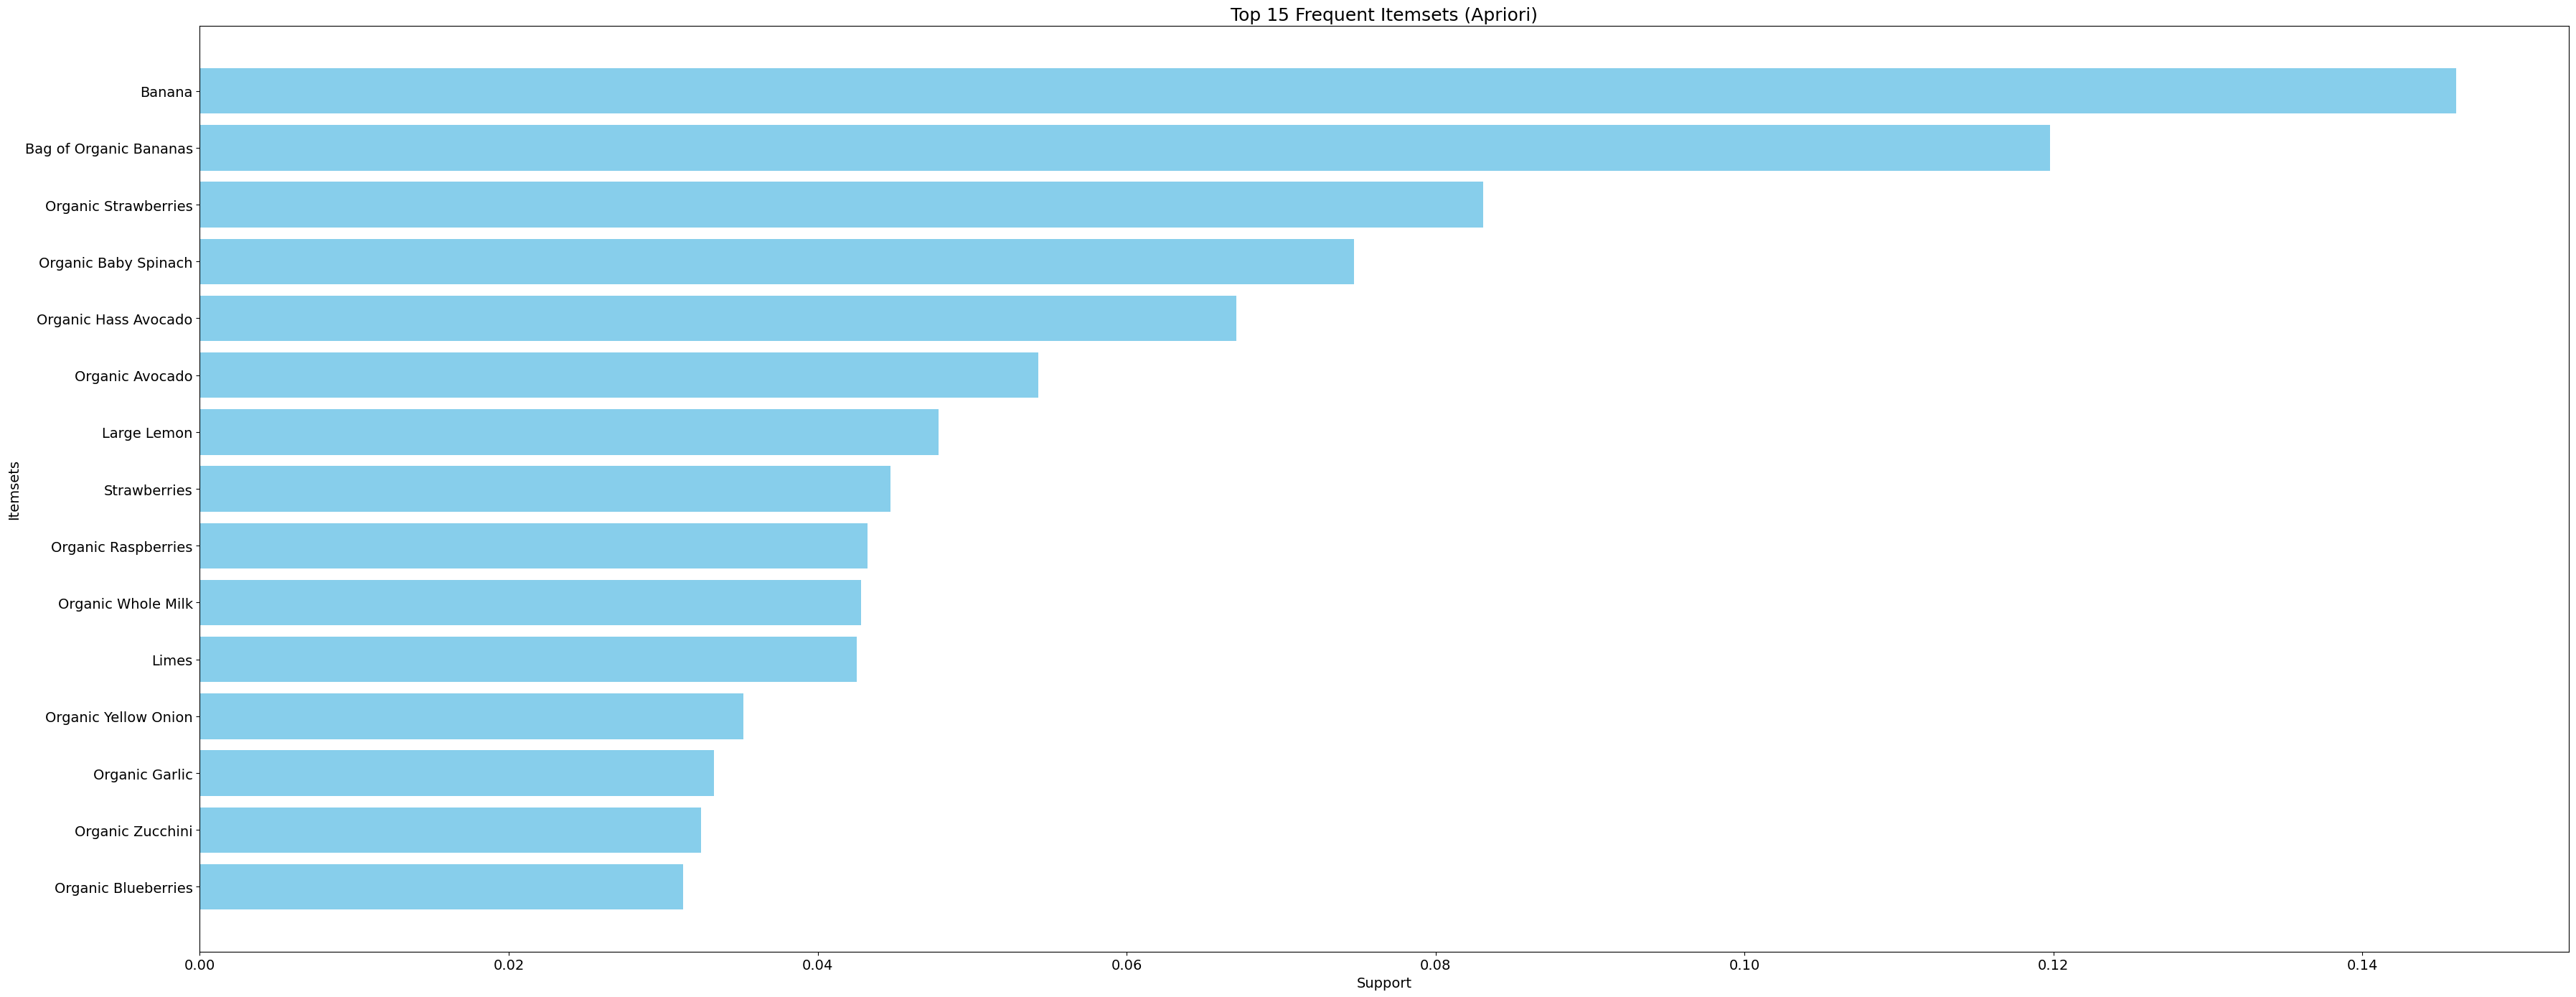

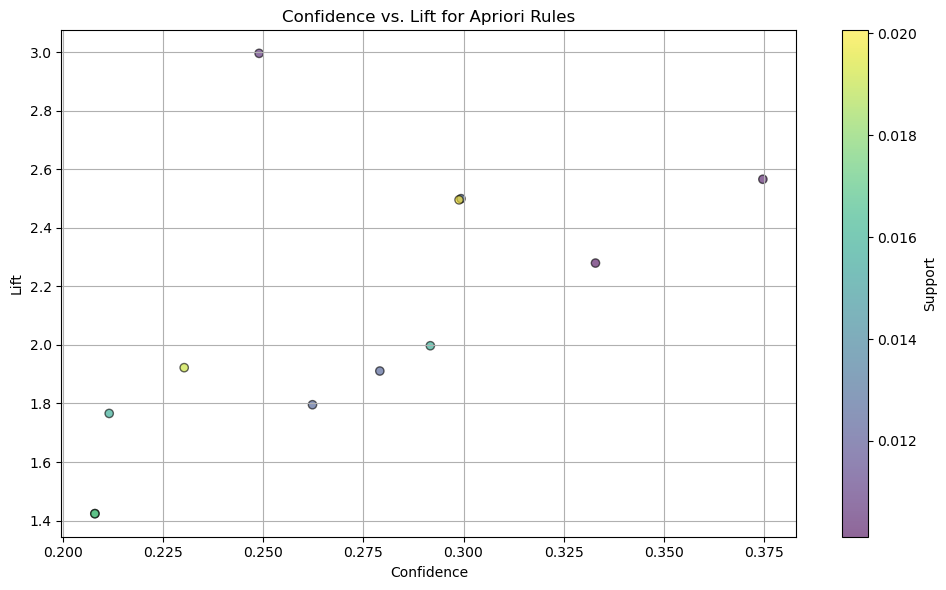

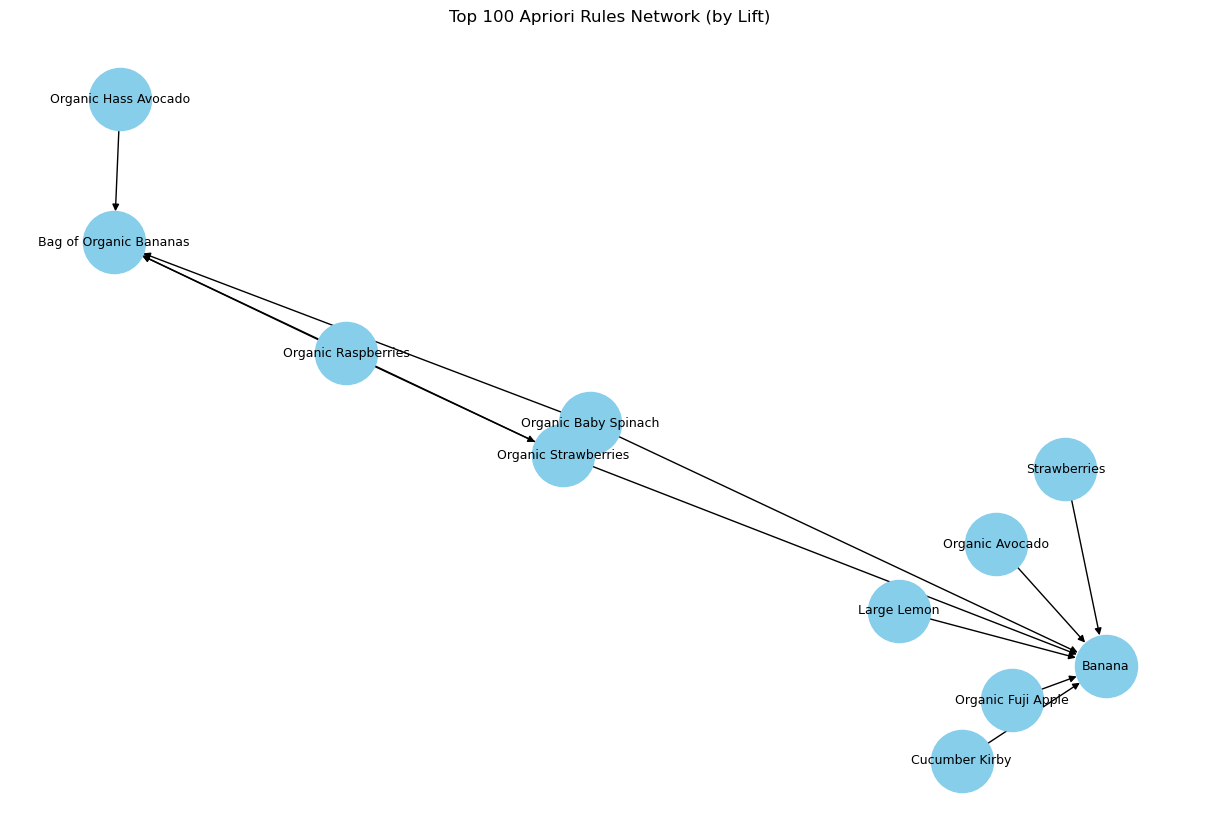

In [7]:


# 🔷 APRIORI ANALYSIS
print("🔷 APRIORI ANALYSIS")


# Convert frozensets to strings for readability
frequent_ap['itemsets_str'] = frequent_ap['itemsets'].apply(lambda x: ', '.join(list(x)))

# Get top 30 itemsets
top30 = frequent_ap.sort_values(by='support', ascending=False).head(15)

# Plot
plt.figure(figsize=(36, 14))  # Larger size
plt.barh(top30['itemsets_str'], top30['support'], color='skyblue')
plt.xlabel("Support", fontsize=14)
plt.ylabel("Itemsets", fontsize=14)
plt.title("Top 15 Frequent Itemsets (Apriori)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(rules_ap['confidence'], rules_ap['lift'], alpha=0.6, c=rules_ap['support'], cmap='viridis', edgecolors='k')
plt.colorbar(label='Support')
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.title("Confidence vs. Lift for Apriori Rules")
plt.grid(True)
plt.tight_layout()
plt.show()


# Network Graph - Apriori
plt.figure(figsize=(12,8))
G_ap = nx.DiGraph()
for _, row in rules_ap.head(100).iterrows():
    for ant in row['antecedents']:
        for con in row['consequents']:
            G_ap.add_edge(ant, con, weight=row['lift'])
pos = nx.spring_layout(G_ap, k=0.5)
nx.draw(G_ap, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=9, arrows=True)
plt.title("Top 100 Apriori Rules Network (by Lift)")
plt.show()


### 4.4 What are the frequent itemsets discovered using the FP-Growth algorithm?

In [8]:
# Summary - Apriori
print("Top 100 Apriori Rules by Confidence:")
display(rules_ap[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

strong_ap = rules_ap[(rules_ap['lift'] > 0.2) & (rules_ap['confidence'] > 0.2)]
print("\nStrong Apriori Rules (lift > 0.2 & confidence > 0.2):")
display(strong_ap[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False))


Top 100 Apriori Rules by Confidence:


,antecedents,consequents,support,confidence,lift
11,(Organic Raspberries),(Organic Strawberries),0.010765,0.248959,2.995720
8,(Organic Fuji Apple),(Banana),0.010390,0.374752,2.565740
2,(Organic Raspberries),(Bag of Organic Bananas),0.012945,0.299376,2.499483
1,(Organic Hass Avocado),(Bag of Organic Bananas),0.020060,0.298890,2.495429
4,(Cucumber Kirby),(Banana),0.010120,0.332949,2.279539
6,(Organic Avocado),(Banana),0.015840,0.291713,1.997211
3,(Organic Strawberries),(Bag of Organic Bananas),0.019135,0.230251,1.922362
10,(Strawberries),(Banana),0.012480,0.279101,1.910865
5,(Large Lemon),(Banana),0.012540,0.262288,1.795757
0,(Organic Baby Spinach),(Bag of Organic Bananas),0.015805,0.211523,1.766003



Strong Apriori Rules (lift > 0.2 & confidence > 0.2):


,antecedents,consequents,support,confidence,lift
11,(Organic Raspberries),(Organic Strawberries),0.010765,0.248959,2.995720
8,(Organic Fuji Apple),(Banana),0.010390,0.374752,2.565740
2,(Organic Raspberries),(Bag of Organic Bananas),0.012945,0.299376,2.499483
1,(Organic Hass Avocado),(Bag of Organic Bananas),0.020060,0.298890,2.495429
4,(Cucumber Kirby),(Banana),0.010120,0.332949,2.279539
6,(Organic Avocado),(Banana),0.015840,0.291713,1.997211
3,(Organic Strawberries),(Bag of Organic Bananas),0.019135,0.230251,1.922362
10,(Strawberries),(Banana),0.012480,0.279101,1.910865
5,(Large Lemon),(Banana),0.012540,0.262288,1.795757
0,(Organic Baby Spinach),(Bag of Organic Bananas),0.015805,0.211523,1.766003


### 4.5 What association rules can be derived from FP-Growth, and how do they compare to Apriori?

In [9]:

# Add readable string columns for antecedents and consequents
strong_ap['antecedents_str'] = strong_ap['antecedents'].apply(lambda x: ', '.join(list(x)))
strong_ap['consequents_str'] = strong_ap['consequents'].apply(lambda x: ', '.join(list(x)))

# Display top rules with explanation annotations
annotated = strong_ap[['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(30)
display(annotated)

for i, row in annotated.iterrows():
    print(f"""
🧾 Rule: IF [{row['antecedents_str']}] THEN [{row['consequents_str']}]
   - Support: {row['support']:.3f} → This rule appears in {row['support']*100:.1f}% of all transactions
   - Confidence: {row['confidence']:.2f} → When people buy [{row['antecedents_str']}], {row['confidence']*100:.1f}% also buy [{row['consequents_str']}]
   - Lift: {row['lift']:.2f} → Buying [{row['antecedents_str']}] makes it {row['lift']:.1f}x more likely to also buy [{row['consequents_str']}] compared to random chance
    """)





,antecedents_str,consequents_str,support,confidence,lift
11,Organic Raspberries,Organic Strawberries,0.010765,0.248959,2.995720
8,Organic Fuji Apple,Banana,0.010390,0.374752,2.565740
2,Organic Raspberries,Bag of Organic Bananas,0.012945,0.299376,2.499483
1,Organic Hass Avocado,Bag of Organic Bananas,0.020060,0.298890,2.495429
4,Cucumber Kirby,Banana,0.010120,0.332949,2.279539
6,Organic Avocado,Banana,0.015840,0.291713,1.997211
3,Organic Strawberries,Bag of Organic Bananas,0.019135,0.230251,1.922362
10,Strawberries,Banana,0.012480,0.279101,1.910865
5,Large Lemon,Banana,0.012540,0.262288,1.795757
0,Organic Baby Spinach,Bag of Organic Bananas,0.015805,0.211523,1.766003



🧾 Rule: IF [Organic Raspberries] THEN [Organic Strawberries]
   - Support: 0.011 → This rule appears in 1.1% of all transactions
   - Confidence: 0.25 → When people buy [Organic Raspberries], 24.9% also buy [Organic Strawberries]
   - Lift: 3.00 → Buying [Organic Raspberries] makes it 3.0x more likely to also buy [Organic Strawberries] compared to random chance
    

🧾 Rule: IF [Organic Fuji Apple] THEN [Banana]
   - Support: 0.010 → This rule appears in 1.0% of all transactions
   - Confidence: 0.37 → When people buy [Organic Fuji Apple], 37.5% also buy [Banana]
   - Lift: 2.57 → Buying [Organic Fuji Apple] makes it 2.6x more likely to also buy [Banana] compared to random chance
    

🧾 Rule: IF [Organic Raspberries] THEN [Bag of Organic Bananas]
   - Support: 0.013 → This rule appears in 1.3% of all transactions
   - Confidence: 0.30 → When people buy [Organic Raspberries], 29.9% also buy [Bag of Organic Bananas]
   - Lift: 2.50 → Buying [Organic Raspberries] makes it 2.5x more like

### 4.6 How do Apriori and FP-Growth compare in terms of performance (speed, scalability)?

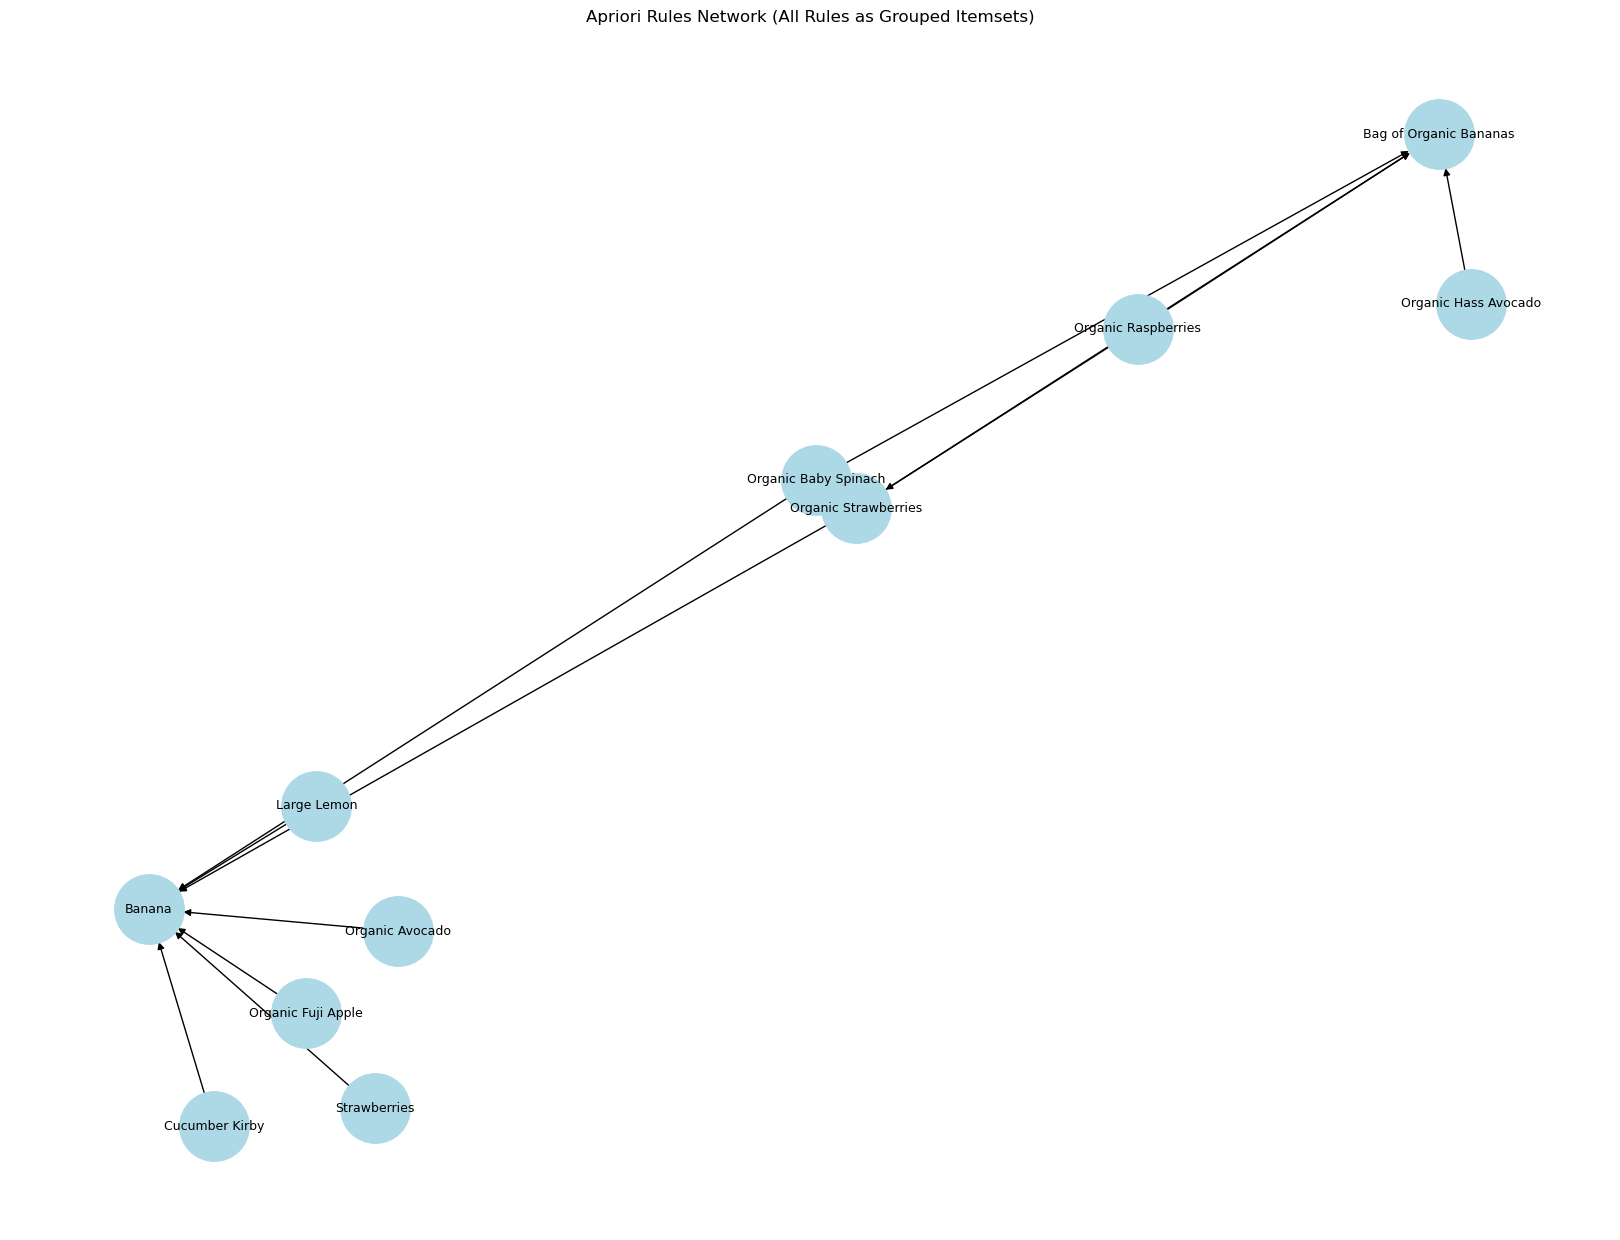

In [10]:
plt.figure(figsize=(16, 12))
G_ap = nx.DiGraph()

for _, row in rules_ap.iterrows():
    ant = ', '.join(row['antecedents'])
    con = ', '.join(row['consequents'])
    G_ap.add_edge(ant, con, weight=row['lift'])

pos = nx.spring_layout(G_ap, k=0.5)
nx.draw(G_ap, pos, with_labels=True, node_size=2500, node_color='lightblue', font_size=9, arrows=True)
plt.title("Apriori Rules Network (All Rules as Grouped Itemsets)")
plt.show()  # no tight_layout

### 4.7 What are the key takeaways from comparing both algorithms?

#  Market Basket Analysis: Detailed Rule Interpretation
This section summarizes the most insightful association rules discovered using the Apriori algorithm. The results are based on transactions from the Instacart dataset.

## ✅ 1. Strong Organic Fruit Associations

- **Rule:** *Organic Raspberries → Organic Strawberries*  
  **Lift:** 3.00 | **Confidence:** 25% | **Support:** 1.1%  
  → Customers who buy organic raspberries are **3× more likely** to also buy organic strawberries than random. Ideal for bundling or BOGO promotions.

- **Rule:** *Organic Raspberries → Bag of Organic Bananas*  
  **Lift:** 2.50 | **Confidence:** 29.9%  
  → Organic shoppers often buy multiple items. Great opportunity for organic combo deals.

- **Rule:** *Organic Hass Avocado → Bag of Organic Bananas*  
  **Lift:** 2.50 | **Confidence:** 30%  
  → Suggests health-conscious baskets—good for breakfast-focused pairings.

- **Rule:** *Organic Strawberries → Bag of Organic Bananas*  
  **Lift:** 1.92 | **Confidence:** 23.0%  
  → Lesser lift but still valuable for bundling related produce.

## ✅ 2. Bananas Are a Common Destination Item

Bananas frequently appear as the **consequent** in rules involving other fresh produce:

| Antecedent              | Confidence | Lift |
|-------------------------|------------|------|
| Organic Fuji Apple      | 37.5%      | 2.57 |
| Cucumber Kirby          | 33.3%      | 2.28 |
| Organic Avocado         | 29.2%      | 2.00 |
| Strawberries            | 27.9%      | 1.91 |
| Large Lemon             | 26.2%      | 1.80 |

→ Bananas act as a **common follow-up** item, making them a key target for upselling and strategic placement near other fruits.


## ✅ 3. Health Basket Insight



- **Rule:** *Organic Baby Spinach → Bag of Organic Bananas*  
  **Lift:** 1.77 | **Confidence:** 21.2%  
  → This combination is commonly used in smoothies or healthy prep baskets. Suggests a niche audience worth targeting.

---

##  Strategic Takeaways

| Area | Recommendation |
|------|----------------|
|  Product Placement | Place **bananas** near avocados, apples, and berries. |
|  Cross-Sell Targets | Suggest strawberries or bananas when raspberries are added. |
|  Bundle Strategy | Create "Organic Essentials" or "Smoothie Starter Kits". |
|  Marketing Copy | Use phrases like “Frequently Bought Together” in product listings. |


# =======================================
#  FP-GROWTH ANALYSIS
# =======================================


🔶 FP-GROWTH ANALYSIS


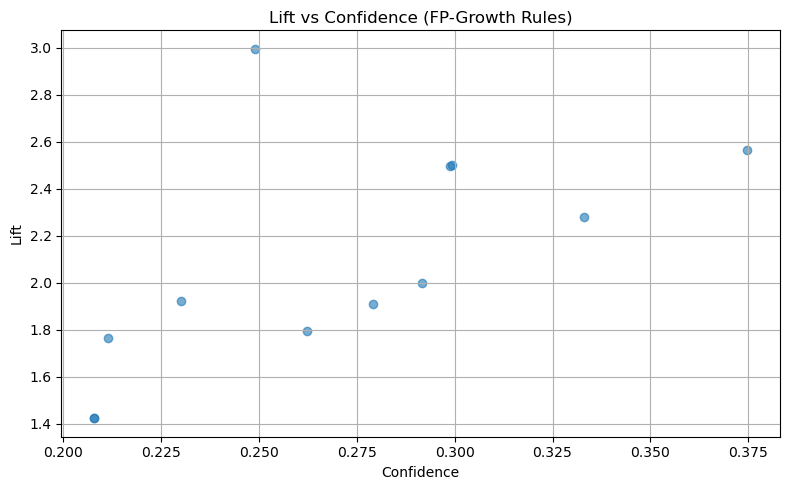

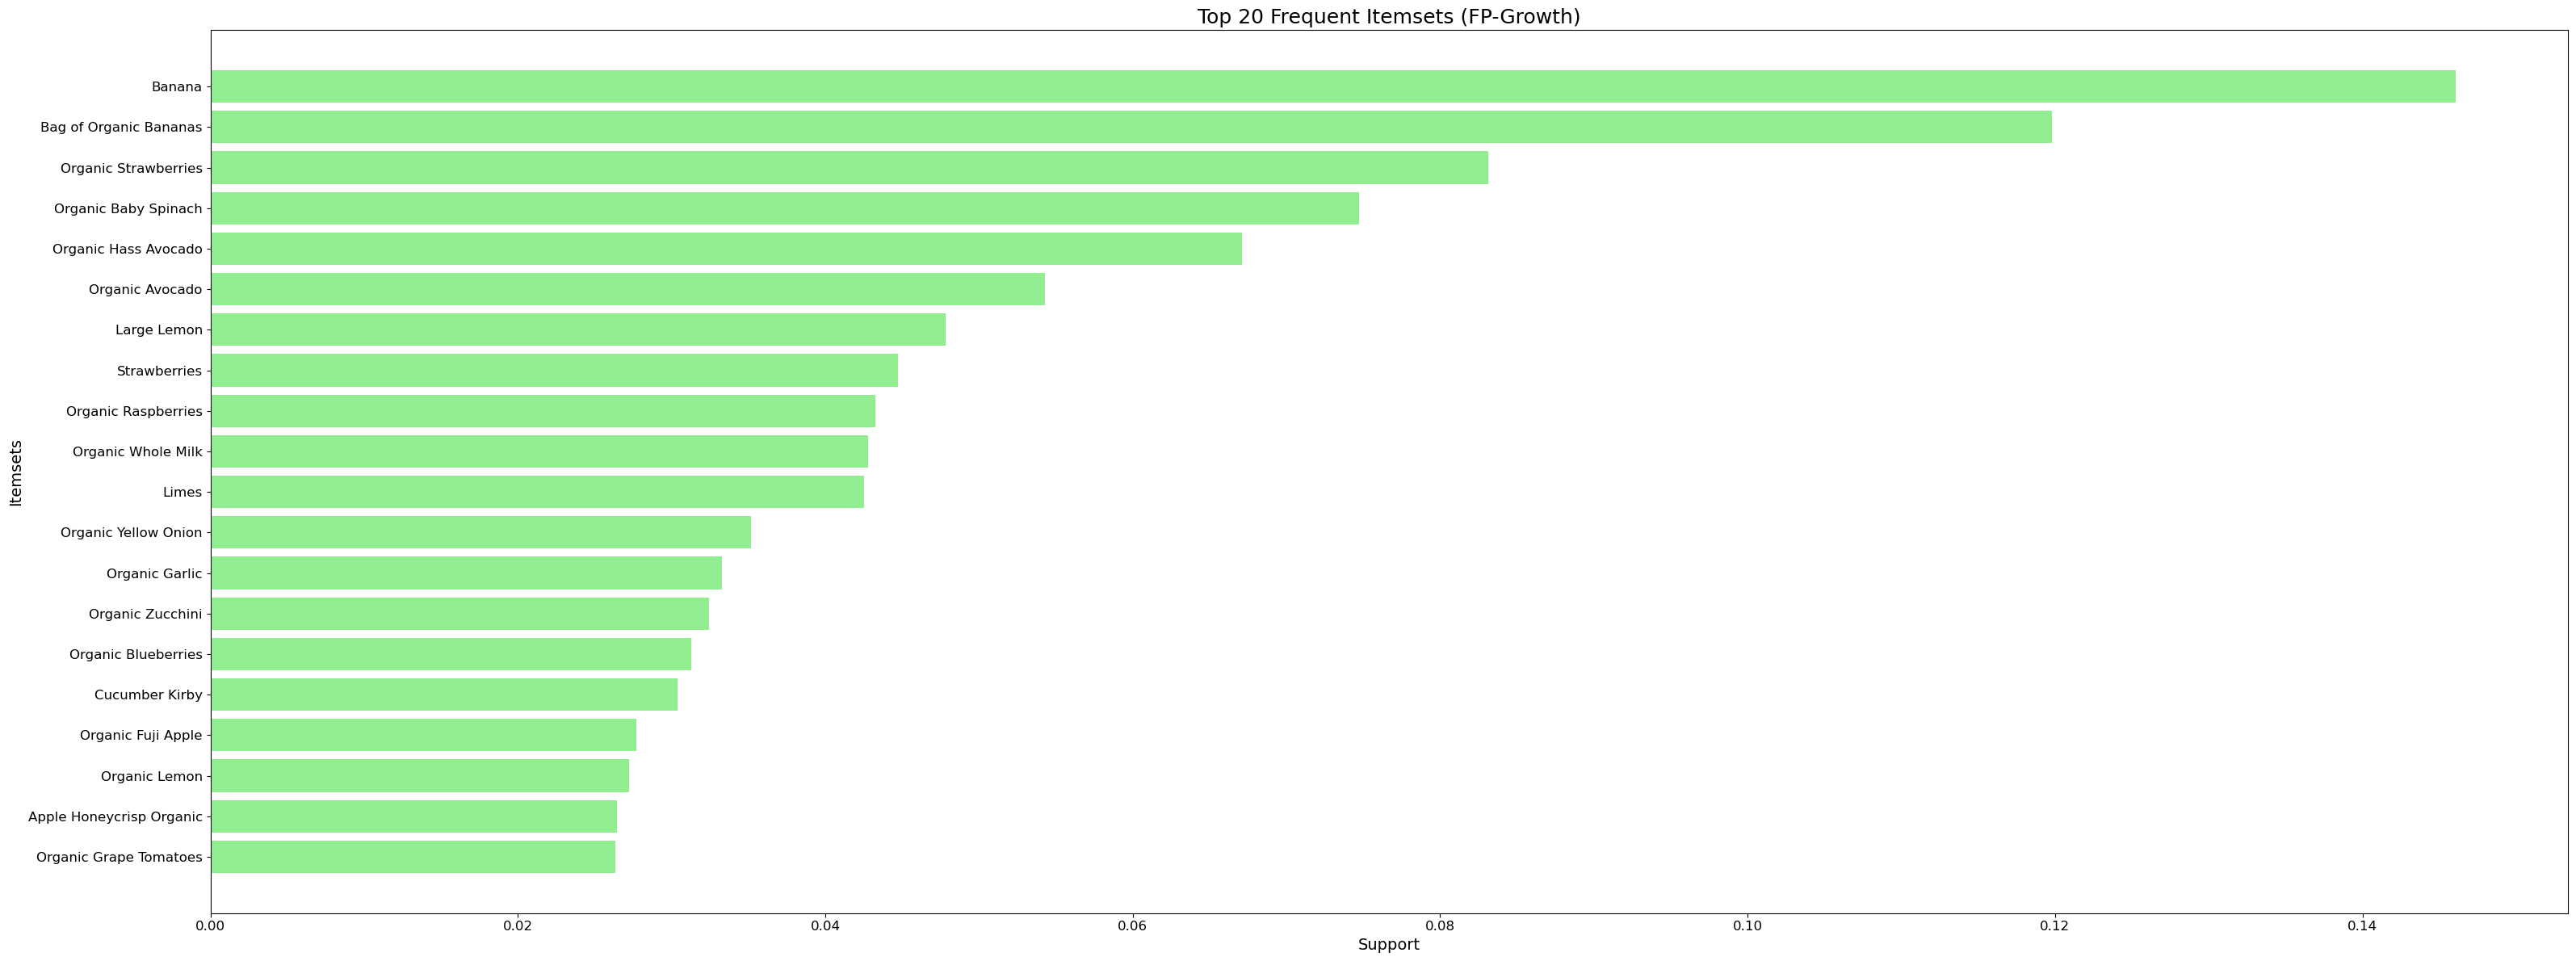

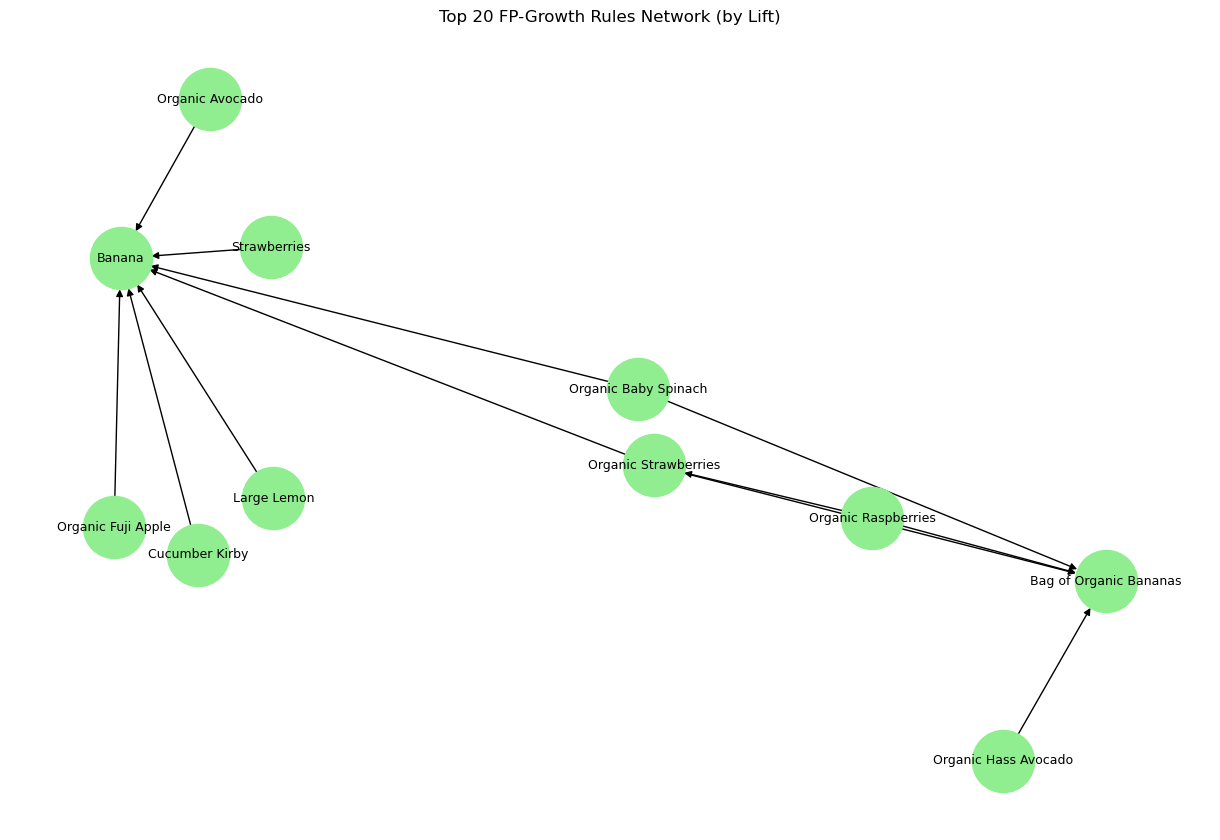

Top 10 FP-Growth Rules by Confidence:


,antecedents,consequents,support,confidence,lift
3,(Organic Raspberries),(Organic Strawberries),0.010765,0.248959,2.995720
4,(Organic Fuji Apple),(Banana),0.010390,0.374752,2.565740
2,(Organic Raspberries),(Bag of Organic Bananas),0.012945,0.299376,2.499483
5,(Organic Hass Avocado),(Bag of Organic Bananas),0.020060,0.298890,2.495429
0,(Cucumber Kirby),(Banana),0.010120,0.332949,2.279539
11,(Organic Avocado),(Banana),0.015840,0.291713,1.997211
6,(Organic Strawberries),(Bag of Organic Bananas),0.019135,0.230251,1.922362
1,(Strawberries),(Banana),0.012480,0.279101,1.910865
8,(Large Lemon),(Banana),0.012540,0.262288,1.795757
9,(Organic Baby Spinach),(Bag of Organic Bananas),0.015805,0.211523,1.766003



Strong FP-Growth Rules (lift > 1.2 & confidence > 0.5):


,antecedents,consequents,support,confidence,lift


In [11]:
# 🔶 FP-GROWTH ANALYSIS
print("\n🔶 FP-GROWTH ANALYSIS")

frequent_fp = fpgrowth(df, min_support=0.01, use_colnames=True)
rules_fp = association_rules(frequent_fp, metric="confidence", min_threshold=0.2)
rules_fp.sort_values(by='lift', ascending=False, inplace=True)

# Lift vs Confidence - FP-Growth
plt.figure(figsize=(8,5))
plt.scatter(rules_fp['confidence'], rules_fp['lift'], alpha=0.6)
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.title("Lift vs Confidence (FP-Growth Rules)")
plt.grid(True)
plt.tight_layout()
plt.show()




# Convert frozensets to strings
frequent_fp['itemsets_str'] = frequent_fp['itemsets'].apply(lambda x: ', '.join(list(x)))

# Get top 20
top20_fp = frequent_fp.sort_values(by='support', ascending=False).head(20)

# Plot
plt.figure(figsize=(32, 12))  # Larger size
plt.barh(top20_fp['itemsets_str'], top20_fp['support'], color='lightgreen')
plt.xlabel("Support", fontsize=14)
plt.ylabel("Itemsets", fontsize=14)
plt.title("Top 20 Frequent Itemsets (FP-Growth)", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



# Network Graph - FP-Growth
plt.figure(figsize=(12,8))
G_fp = nx.DiGraph()
for _, row in rules_fp.head(20).iterrows():
    for ant in row['antecedents']:
        for con in row['consequents']:
            G_fp.add_edge(ant, con, weight=row['lift'])
pos = nx.spring_layout(G_fp, k=0.5)
nx.draw(G_fp, pos, with_labels=True, node_size=2000, node_color='lightgreen', font_size=9, arrows=True)
plt.title("Top 20 FP-Growth Rules Network (by Lift)")
plt.show()

# Summary - FP-Growth
print("Top 10 FP-Growth Rules by Confidence:")
display(rules_fp[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

strong_fp = rules_fp[(rules_fp['lift'] > 1.2) & (rules_fp['confidence'] > 0.5)]
print("\nStrong FP-Growth Rules (lift > 1.2 & confidence > 0.5):")
display(strong_fp[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10))

In [12]:
print("Top 100 FP-Growth Rules by Confidence:")
display(rules_fp[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

strong_fp = rules_fp[(rules_fp['lift'] > 0.01) & (rules_fp['confidence'] > 0.03)]
print("\nStrong FP-Growth Rules (lift > 0.01 & confidence > 0.03):")
display(strong_fp[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False))


# Add readable string columns for antecedents and consequents
strong_fp['antecedents_str'] = strong_fp['antecedents'].apply(lambda x: ', '.join(list(x)))
strong_fp['consequents_str'] = strong_fp['consequents'].apply(lambda x: ', '.join(list(x)))

# Display top annotated rules
annotated_fp = strong_fp[['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift']]\
                    .sort_values(by='lift', ascending=False).head(10)

# Print detailed explanation for each rule
for i, row in annotated_fp.iterrows():
    print(f"""
🧾 [FP-Growth] Rule: IF [{row['antecedents_str']}] THEN [{row['consequents_str']}]
   - Support: {row['support']:.3f} → This rule appears in {row['support']*100:.1f}% of all transactions
   - Confidence: {row['confidence']:.2f} → When people buy [{row['antecedents_str']}], {row['confidence']*100:.1f}% also buy [{row['consequents_str']}]
   - Lift: {row['lift']:.2f} → Buying [{row['antecedents_str']}] makes it {row['lift']:.1f}x more likely to also buy [{row['consequents_str']}] compared to random chance
    """)

Top 100 FP-Growth Rules by Confidence:


,antecedents,consequents,support,confidence,lift
3,(Organic Raspberries),(Organic Strawberries),0.010765,0.248959,2.995720
4,(Organic Fuji Apple),(Banana),0.010390,0.374752,2.565740
2,(Organic Raspberries),(Bag of Organic Bananas),0.012945,0.299376,2.499483
5,(Organic Hass Avocado),(Bag of Organic Bananas),0.020060,0.298890,2.495429
0,(Cucumber Kirby),(Banana),0.010120,0.332949,2.279539
11,(Organic Avocado),(Banana),0.015840,0.291713,1.997211
6,(Organic Strawberries),(Bag of Organic Bananas),0.019135,0.230251,1.922362
1,(Strawberries),(Banana),0.012480,0.279101,1.910865
8,(Large Lemon),(Banana),0.012540,0.262288,1.795757
9,(Organic Baby Spinach),(Bag of Organic Bananas),0.015805,0.211523,1.766003



Strong FP-Growth Rules (lift > 0.01 & confidence > 0.03):


,antecedents,consequents,support,confidence,lift
3,(Organic Raspberries),(Organic Strawberries),0.010765,0.248959,2.995720
4,(Organic Fuji Apple),(Banana),0.010390,0.374752,2.565740
2,(Organic Raspberries),(Bag of Organic Bananas),0.012945,0.299376,2.499483
5,(Organic Hass Avocado),(Bag of Organic Bananas),0.020060,0.298890,2.495429
0,(Cucumber Kirby),(Banana),0.010120,0.332949,2.279539
11,(Organic Avocado),(Banana),0.015840,0.291713,1.997211
6,(Organic Strawberries),(Bag of Organic Bananas),0.019135,0.230251,1.922362
1,(Strawberries),(Banana),0.012480,0.279101,1.910865
8,(Large Lemon),(Banana),0.012540,0.262288,1.795757
9,(Organic Baby Spinach),(Bag of Organic Bananas),0.015805,0.211523,1.766003



🧾 [FP-Growth] Rule: IF [Organic Raspberries] THEN [Organic Strawberries]
   - Support: 0.011 → This rule appears in 1.1% of all transactions
   - Confidence: 0.25 → When people buy [Organic Raspberries], 24.9% also buy [Organic Strawberries]
   - Lift: 3.00 → Buying [Organic Raspberries] makes it 3.0x more likely to also buy [Organic Strawberries] compared to random chance
    

🧾 [FP-Growth] Rule: IF [Organic Fuji Apple] THEN [Banana]
   - Support: 0.010 → This rule appears in 1.0% of all transactions
   - Confidence: 0.37 → When people buy [Organic Fuji Apple], 37.5% also buy [Banana]
   - Lift: 2.57 → Buying [Organic Fuji Apple] makes it 2.6x more likely to also buy [Banana] compared to random chance
    

🧾 [FP-Growth] Rule: IF [Organic Raspberries] THEN [Bag of Organic Bananas]
   - Support: 0.013 → This rule appears in 1.3% of all transactions
   - Confidence: 0.30 → When people buy [Organic Raspberries], 29.9% also buy [Bag of Organic Bananas]
   - Lift: 2.50 → Buying [Organic 

#  FP-Growth Association Rule Summary
This section presents the strongest association rules discovered using the **FP-Growth algorithm** on transactional data from Instacart. FP-Growth is a faster alternative to Apriori and excels in large datasets with many items.

The following rules were selected based on `lift > 1.0` and `confidence > 0.03`. They represent highly interesting product combinations.


### Example Highlights:

- **Rule:** *Organic Fuji Apple → Banana*  
  - **Support:** 1.0%  
  - **Confidence:** 37.5%  
  - **Lift:** 2.57  
  → Shoppers who buy Organic Fuji Apples are **2.6× more likely** to also buy Bananas than expected at random.

- **Rule:** *Organic Raspberries → Organic Strawberries*  
  - **Support:** 1.1%  
  - **Confidence:** 24.9%  
  - **Lift:** 3.00  
  → This indicates a very strong pair of complementary organic fruits. Excellent for combo deals.

- **Rule:** *Cucumber Kirby → Banana*  
  - **Support:** 1.0%  
  - **Confidence:** 33.3%  
  - **Lift:** 2.28  
  → Suggests strong overlap between shoppers looking for salad/fresh produce items.

---

##  Business Insights from FP-Growth

| Insight Type       | Observation |
|--------------------|-------------|
|  Banana Affinity | Multiple antecedents such as Organic Apple, Cucumber Kirby, and Avocado lead to Banana |
|  Organic Pairing | Organic fruit combos (e.g., Raspberries + Strawberries) have strong lift |
|  Smoothie Basket | Items like Organic Spinach & Bananas often occur together |

---

##  Why FP-Growth?

- ✅ **Scalable:** Handles millions of transactions efficiently
- ✅ **Fast:** Does not require candidate generation like Apriori
- ✅ **Accurate:** Produces identical rules when parameters are the same

---

## 🛠 Suggested Applications

- "Add to Cart" recommendations
- Cross-selling in online grocery platforms
- Personalized bundle generation
- In-store placement optimization

In [16]:

# Find overlapping itemsets
overlap = set(frequent_ap['itemsets']).intersection(set(frequent_fp['itemsets']))
print(f"Number of overlapping frequent itemsets: {len(overlap)}")

# Compare lift values for matching rules (based on string match of antecedents+consequents)
ap_rules = rules_ap.copy()
ap_rules['rule'] = ap_rules['antecedents'].apply(lambda x: ','.join(sorted(x))) + ' → ' + ap_rules['consequents'].apply(lambda x: ','.join(sorted(x)))
fp_rules = rules_fp.copy()
fp_rules['rule'] = fp_rules['antecedents'].apply(lambda x: ','.join(sorted(x))) + ' → ' + fp_rules['consequents'].apply(lambda x: ','.join(sorted(x)))

merged_rules = pd.merge(ap_rules[['rule', 'lift']], fp_rules[['rule', 'lift']], on='rule', suffixes=('_apriori', '_fp_growth'))
print("Sample comparison of lift values for overlapping rules:")
display(merged_rules.sort_values(by='lift_apriori', ascending=False))

Number of overlapping frequent itemsets: 191
Sample comparison of lift values for overlapping rules:


,rule,lift_apriori,lift_fp_growth
17,Carrots → Organic Red Onion,12.019231,12.019231
16,Organic Red Onion → Carrots,12.019231,12.019231
19,Organic Cilantro → Limes,8.361204,8.361204
18,Organic Ginger Root → Large Lemon,7.396450,7.396450
20,Organic Italian Parsley Bunch → Organic Baby S...,6.944444,6.944444
24,Organic Small Bunch Celery → Organic Strawberries,5.081301,5.081301
22,Organic Ginger Root → Organic Hass Avocado,4.370629,4.370629
14,Small Hass Avocado → Banana,4.340278,4.340278
7,Organic D'Anjou Pears → Banana,4.340278,4.340278
23,Organic Lemon → Organic Hass Avocado,3.933566,3.933566


###  Additional Data Load and Full Pipeline Comparison 

In [ ]:
# Load full Instacart dataset
products = pd.read_csv(f"{base_path}\\products.csv")
order_products_prior = pd.read_csv(f"{base_path}\\order_products__prior.csv")

In [18]:
# Sample, preprocess, run Apriori and FP-Growth, and compare outputs
merged = order_products_prior.merge(products, on='product_id', how='left')
sample_orders = merged['order_id'].drop_duplicates().sample(500, random_state=42)
merged_sample = merged[merged['order_id'].isin(sample_orders)]
transactions = merged_sample.groupby('order_id')['product_name'].apply(list).tolist()

te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_array, columns=te.columns_)

frequent_ap = apriori(df, min_support=0.01, use_colnames=True)
rules_ap = association_rules(frequent_ap, metric="confidence", min_threshold=0.3)

frequent_fp = fpgrowth(df, min_support=0.01, use_colnames=True)
rules_fp = association_rules(frequent_fp, metric="confidence", min_threshold=0.3)

print(f"Apriori found {len(rules_ap)} rules")
print(f"FP-Growth found {len(rules_fp)} rules")

print("Top Apriori rules by confidence:")
print(rules_ap.sort_values(by="confidence", ascending=False).head())

print("\nTop FP-Growth rules by confidence:")
print(rules_fp.sort_values(by="confidence", ascending=False).head())

Apriori found 25 rules
FP-Growth found 25 rules
Top Apriori rules by confidence:
                 antecedents consequents  antecedent support  \
14      (Small Hass Avocado)    (Banana)               0.016   
7    (Organic D'Anjou Pears)    (Banana)               0.016   
0   (100% Whole Wheat Bread)    (Banana)               0.022   
15            (Strawberries)    (Banana)               0.044   
4           (Cucumber Kirby)    (Banana)               0.024   

    consequent support  support  confidence      lift  representativity  \
14               0.144    0.010    0.625000  4.340278               1.0   
7                0.144    0.010    0.625000  4.340278               1.0   
0                0.144    0.012    0.545455  3.787879               1.0   
15               0.144    0.022    0.500000  3.472222               1.0   
4                0.144    0.012    0.500000  3.472222               1.0   

    leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
14  0.00